# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
#target = 'bandgap'
folder = 'MP-Fv-500-T'
#folder = 'MChX-bandgap'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std':      f'{r_folder}/ref_dataset_std.pt',
    'r_std_parameters':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data': f'{r_folder}/uncertainty_data.json',
    'model':              f'{r_folder}/model.pt',
    'dataset_parameters': f'{r_folder}/dataset_parameters.json',
    't_dataset':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
# Note that you can as well load a non-standardized dataset and
# then use the cld.standardize_dataset_from_keys function
r_dataset_std = torch.load(files_names['r_dataset_std'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters'])

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dataset_parameters'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Target dataset

In [5]:
# Load the standardized dataset, with corresponding labels and parameters
# We provide the cld.generate_dataset to generate the dataset
# from an existing database if this does not exist yet
t_dataset = torch.load(files_names['t_dataset'], weights_only=False)

# Extract the ground-truths, or input them manually
# This is only requested for testing the performance of the method, not for actual production
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(5, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
import importlib
importlib.reload(clm)

In [ ]:
# Compute predictions with uncertainty estimation
predictions, uncertainties, are_interpolated = clm.forward_predictions(r_dataset_std,
                                                                       t_dataset_std,
                                                                       model, r_std_parameters, r_uncertainty_data)

# Plot predictions

In [ ]:
# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp = np.abs(uncertainties[are_interpolated])

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra = np.abs(uncertainties[~are_interpolated])

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')  # Predictions
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y - err, y + err], 'b')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-abs-prediction-comparison-500.pdf', dpi=50, bbox_inches='tight')
plt.show()

In [ ]:
random_integers = np.random.randint(0, len(ground_truths)+1, size=50)
random_integers

ground_truths_x = ground_truths[random_integers]
predictions_x = predictions[random_integers]
uncertainties_x = np.abs(uncertainties)[random_integers]
are_interpolated_x = are_interpolated[random_integers]

# Extract and plot interpolation data
xpred_interp = ground_truths_x[are_interpolated_x]
ypred_interp = predictions_x[are_interpolated_x]
yerr_interp = uncertainties_x[are_interpolated_x]

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g--')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths_x[~are_interpolated_x]
ypred_extra = predictions_x[~are_interpolated_x]
yerr_extra = uncertainties_x[~are_interpolated_x]

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')  # Predictions
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y - err, y + err], 'b--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths_x + np.abs(uncertainties_x),
    ground_truths_x - np.abs(uncertainties_x),
    predictions_x
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-prediction-comparison-500.pdf', dpi=50, bbox_inches='tight')
plt.show()

In [ ]:
# Check which ones have labeles materials with rare elements or complex formulas,
# and if those are related to bad performance (this was checked for bandgap prediction)

In [ ]:
import re

In [55]:
exclude_elements = ['Po', 'Ac', 'Tc', 'Cf', 'Bk', 'Cm', 'Pu', 'Am', 'Np', 'Pm',
                    'Ir', 'Pt', 'Rb', 'Os', 'Ru', 'Tl', 'Sc', 'Re', 'Th', 'Tm']

In [14]:
#dataaaaa = torch.load(f'/home/claudio/cibran/Work/UPC/CLUE/targets/MP-Fv-500-T/dataset.pt', weights_only=False)

In [ ]:
#torch.save(new_target, f'/home/claudio/cibran/Work/UPC/CLUE/targets/MP-Fv-500-T/dataset.pt')

In [17]:
new_target = []
for data in dataaaaa:
    if data.x[0][-1] == 500:
        new_target.append(data)
        print(data)

Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[12, 5], edge_index=[2, 226], edge_attr=[226, 1], y=[1], label='AlClCu mp-28020-20180417')
Data(x=[16, 5], edge_index=[2, 228], edge_attr=[228, 1], y=[1], label='KPTe 23606')
Data(x=[8, 5], edge_index=[2, 152], edge_attr=[152, 1], y=[1], label='HK mp-24084-20180417')
Data(x=[56, 5], edge_index=[2, 1114], edge_attr=[1114, 1], y=[1], label='NaGaS mp-561130-20180417')
Data(x=[12, 5], edge_index=[2, 328], edge_attr=[328, 1], y=[1], label='FPb mp-315-20180417')
Data(x=[14, 5], edge_index=[2, 322], edge_attr=[322, 1], y=[1], label='GaNSr 24307')
Data(x=[6, 5], edge_index=[2, 164], edge_attr=[164, 1], y=[1], label='OHg mp-7826-20180417')
Data(x=[4, 5], edge_index=[2, 83], edge_attr=[83, 1], y=[1], label='GaKS 1747742')
Data(x=[8, 5], edge_index=[2, 142], edge_attr=[142, 1], y=[1], label='ClNd mp-23183-20180417')
Data(x=[22, 5], edge_index=[2, 238], edge_attr=[238, 1], y=[1], label='OSrI mp-29

In [67]:
t_dataset_std[1].y

tensor([86.1251])

In [72]:
r_dataset_std[2].x

tensor([[ -7.4475,  -7.9538,  -2.1279,  -3.3023,   0.0000],
        [ -7.4475,  -7.9538,  -2.1279,  -3.3023,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -8.8869,  -9.4248,  -0.8176,   8.2515,   0.0000],
        [ -3.2936,  -2.8052, -12.1189, -11.9350,   0.0000],
        [ -3.2936,  -2.8052, -12.1189, -11.9350,   0.0000]])

In [65]:
t_dataset_std_cleaved = []
for data in t_dataset_std:
    valid = True
    label = data.label.split()[0]
    elements = re.findall('[A-Z][^A-Z]*', label)
    print(data)
    for element in elements:
        if element in exclude_elements:
            print(f'{label} with {element} identified')
            valid = False
            break
    if valid:
        t_dataset_std_cleaved.append(data)

Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114, 1], y=[1], label='KZnSb mp-7438-20180417')
Data(x=[6, 5], edge_index=[2, 114], edge_attr=[114

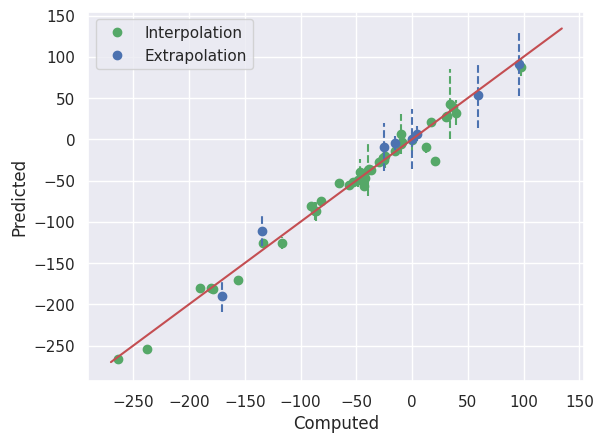

In [48]:
novelty_k = 20

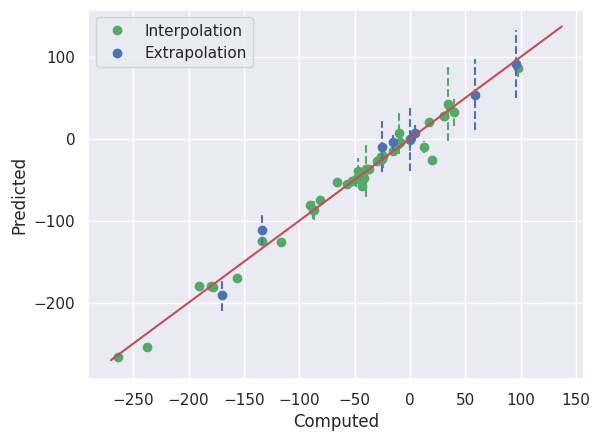

In [45]:
novelty_k = 10

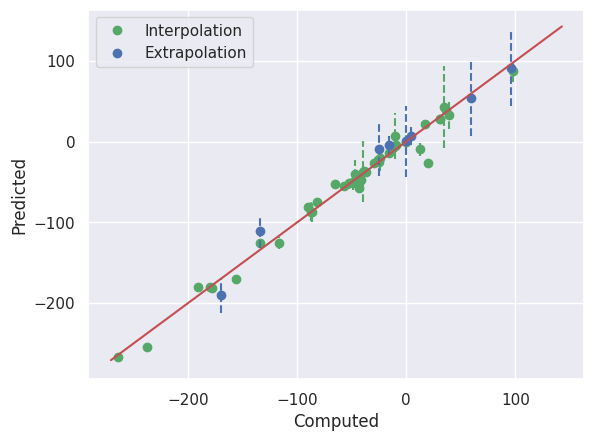

In [42]:
novelty_k = 5

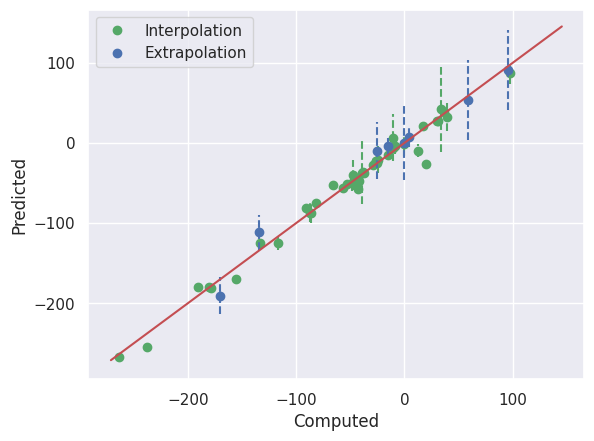

In [39]:
novelty_k = 4

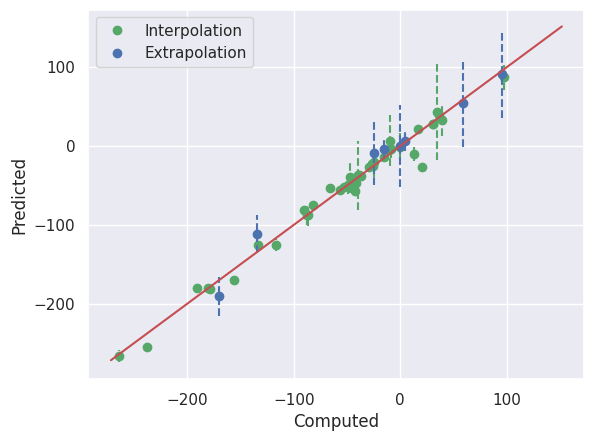

In [36]:
novelty_k = 3

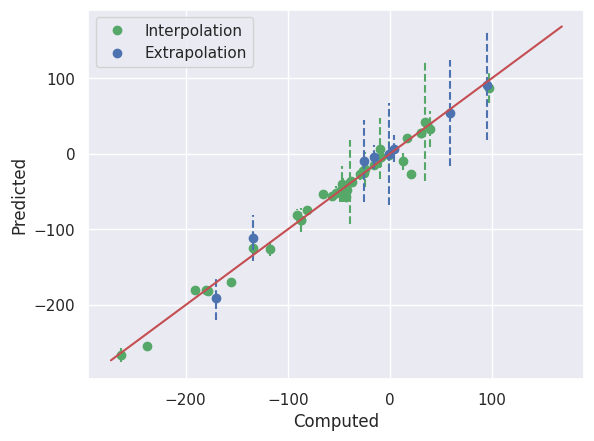

In [33]:
novelty_k = 2

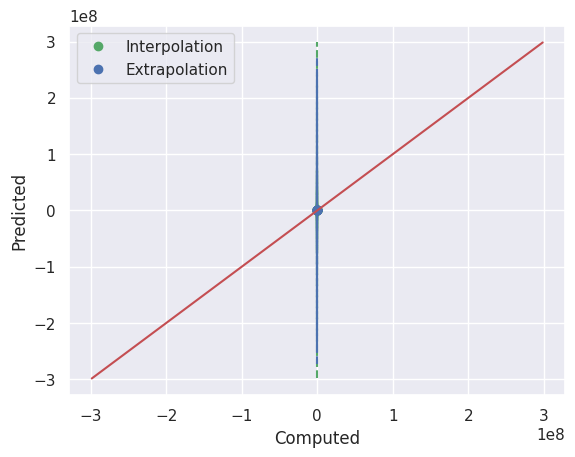

In [30]:
novelty_k = 1

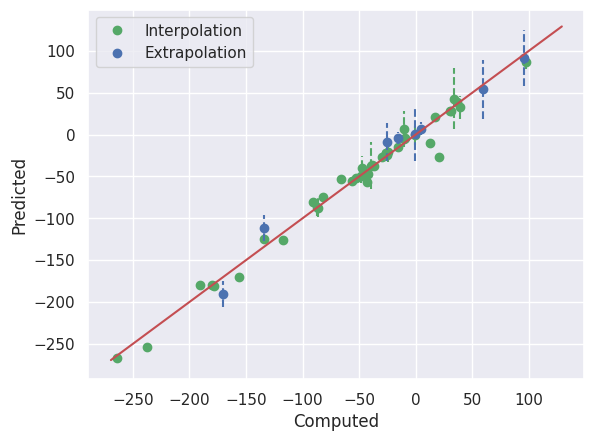

In [ ]:
print('Extrapolated:')
for i, data in enumerate(t_dataset_std):
    if not are_interpolated[i]:
        print(data.label, ground_truths[i])

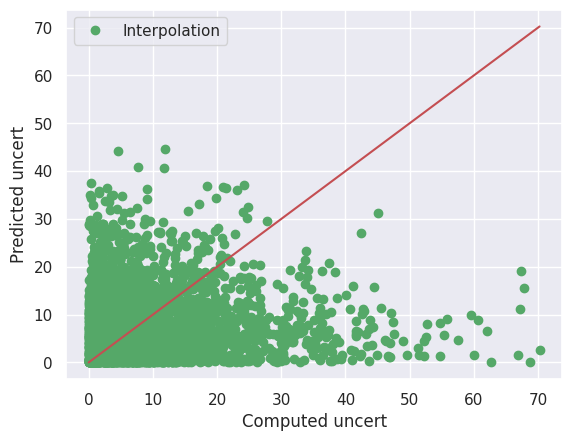

In [23]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

_min_, _max_ = cld.get_min_max([xpred, ypred])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

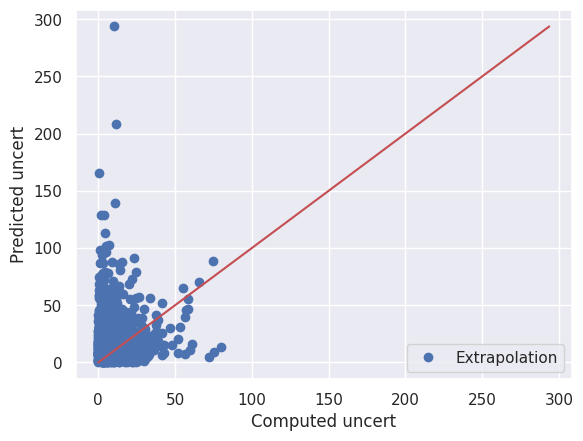

In [24]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([xpred, ypred])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

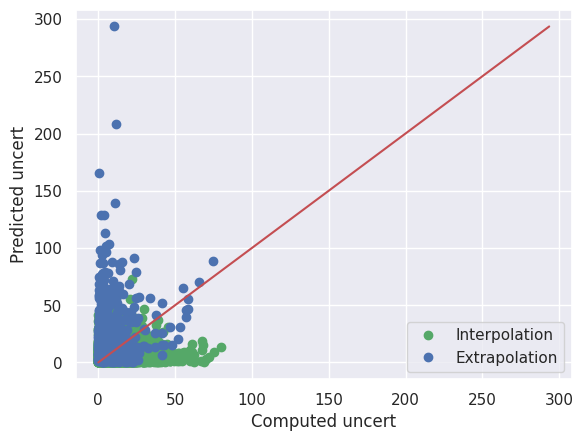

In [15]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()